In [27]:
import requests
import pandas as pd
import time
pd.set_option('max_rows',500)

In [28]:
headers = {'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

In [29]:
url = 'https://c.m.163.com/ug/api/wuhan/app/data/list-total' # 定义要访问的地址
r = requests.get(url, headers=headers) # 使用requests发起请求

In [30]:
print(r.status_code)

200


In [31]:
print(type(r.text))
print(len(r.text))

<class 'str'>
351640


In [32]:
import json
data_json = json.loads(r.text)
type(data_json)
data_json.keys()

dict_keys(['reqId', 'code', 'msg', 'data', 'timestamp'])

In [33]:
data=data_json['data']
data.keys()

dict_keys(['chinaTotal', 'chinaDayList', 'lastUpdateTime', 'overseaLastUpdateTime', 'areaTree'])

In [34]:
data_province = data['areaTree'][2]['children'] # 取出中国各省的实时数据children
type(data_province)

list

In [35]:
data_HuBei=data_province[0]['children']
type(data_HuBei)

list

In [36]:
for i in range(len(data_province)):
    print(data_province[i]['name'],data_province[i]['lastUpdateTime'])
    if i ==5:
        break

湖北 2020-10-13 00:00:24
香港 2020-10-13 00:00:24
广东 2020-10-13 08:35:34
浙江 2020-10-13 00:00:24
河南 2020-10-13 00:00:24
上海 2020-10-13 08:00:33


In [37]:
for i in range(len(data_HuBei)): # 遍历查看湖北省各地区名称、更新时间
    print(data_HuBei[i]['name'],data_HuBei[i]['lastUpdateTime'])
    if i == 5:
        break

武汉 2020-10-13 00:00:24
孝感 2020-10-13 00:00:24
黄冈 2020-10-13 00:00:24
荆州 2020-10-13 00:00:24
鄂州 2020-10-13 00:00:24
随州 2020-10-13 00:00:24


In [38]:
info = pd.DataFrame(data_province)[['id','lastUpdateTime','name']]
info.head()

,id,lastUpdateTime,name
0,420000,2020-10-13 00:00:24,湖北
1,810000,2020-10-13 00:00:24,香港
2,440000,2020-10-13 08:35:34,广东
3,330000,2020-10-13 00:00:24,浙江
4,410000,2020-10-13 00:00:24,河南


In [39]:
today_data = pd.DataFrame([province['today'] for province in data_province ])
today_data.head()

,confirm,suspect,heal,dead,severe,storeConfirm
0,0,None,0,0,None,0
1,7,None,7,0,None,11
2,3,None,0,0,None,3
3,0,None,0,0,None,0
4,0,None,0,0,None,0


In [40]:
today_data.shape
['today_'+i for i in today_data.columns]

['today_confirm',
 'today_suspect',
 'today_heal',
 'today_dead',
 'today_severe',
 'today_storeConfirm']

In [41]:
today_data.columns = ['today_'+i for i in today_data.columns] 
today_data.head()

,today_confirm,today_suspect,today_heal,today_dead,today_severe,today_storeConfirm
0,0,None,0,0,None,0
1,7,None,7,0,None,11
2,3,None,0,0,None,3
3,0,None,0,0,None,0
4,0,None,0,0,None,0


In [42]:
# 获取total中的数据
total_data = pd.DataFrame([province['total'] for province in data_province ])
total_data.columns = ['total_'+i for i in total_data.columns]
total_data.head()

,total_confirm,total_suspect,total_heal,total_dead,total_severe,total_input,total_newConfirm,total_newDead,total_newHeal
0,68139,0,63627,4512,0,0,NaN,NaN,NaN
1,5193,0,4921,105,0,0,NaN,NaN,NaN
2,1863,0,1825,8,0,0,NaN,NaN,NaN
3,1283,0,1272,1,0,0,NaN,NaN,NaN
4,1281,0,1255,22,0,0,NaN,NaN,NaN


In [43]:
total_data.shape
pd.concat([info,total_data,today_data],axis=1).head()

,id,lastUpdateTime,name,total_confirm,total_suspect,total_heal,total_dead,total_severe,total_input,total_newConfirm,total_newDead,total_newHeal,today_confirm,today_suspect,today_heal,today_dead,today_severe,today_storeConfirm
0,420000,2020-10-13 00:00:24,湖北,68139,0,63627,4512,0,0,NaN,NaN,NaN,0,None,0,0,None,0
1,810000,2020-10-13 00:00:24,香港,5193,0,4921,105,0,0,NaN,NaN,NaN,7,None,7,0,None,11
2,440000,2020-10-13 08:35:34,广东,1863,0,1825,8,0,0,NaN,NaN,NaN,3,None,0,0,None,3
3,330000,2020-10-13 00:00:24,浙江,1283,0,1272,1,0,0,NaN,NaN,NaN,0,None,0,0,None,0
4,410000,2020-10-13 00:00:24,河南,1281,0,1255,22,0,0,NaN,NaN,NaN,0,None,0,0,None,0


In [44]:
# 将提取数据的方法封装为函数
def get_data(data,info_list):
 info = pd.DataFrame(data)[info_list] # 主要信息
 
 today_data = pd.DataFrame([i['today'] for i in data ]) # 提取today的数据
 today_data.columns= ['today_'+i for i in today_data.columns] # 修改列名 columns
 
 total_data = pd.DataFrame([i['total'] for i in data ]) # 提取total的数据
 total_data.columns = ['total_'+i for i in total_data.columns] # 修改列名 columns
 
 return pd.concat([info,total_data,today_data],axis=1) # info、today和total横向合并最 终得到汇总的数据
today_province = get_data(data_province,['id','lastUpdateTime','name'])
today_province.head()

,id,lastUpdateTime,name,total_confirm,total_suspect,total_heal,total_dead,total_severe,total_input,total_newConfirm,total_newDead,total_newHeal,today_confirm,today_suspect,today_heal,today_dead,today_severe,today_storeConfirm
0,420000,2020-10-13 00:00:24,湖北,68139,0,63627,4512,0,0,NaN,NaN,NaN,0,None,0,0,None,0
1,810000,2020-10-13 00:00:24,香港,5193,0,4921,105,0,0,NaN,NaN,NaN,7,None,7,0,None,11
2,440000,2020-10-13 08:35:34,广东,1863,0,1825,8,0,0,NaN,NaN,NaN,3,None,0,0,None,3
3,330000,2020-10-13 00:00:24,浙江,1283,0,1272,1,0,0,NaN,NaN,NaN,0,None,0,0,None,0
4,410000,2020-10-13 00:00:24,河南,1281,0,1255,22,0,0,NaN,NaN,NaN,0,None,0,0,None,0


In [45]:
def save_data(data,name): # 定义保存数据方法
 file_name = name+'_'+time.strftime('%Y_%m_%d',time.localtime(time.time()))+'.csv'
 data.to_csv(file_name,index=None,encoding='utf_8_sig')
 print(file_name+' 保存成功！')
time.strftime('%Y_%m_%d',time.localtime(time.time()))
'2020_03_25'
save_data(today_province,'today_province')

today_province_2020_10_13.csv 保存成功！


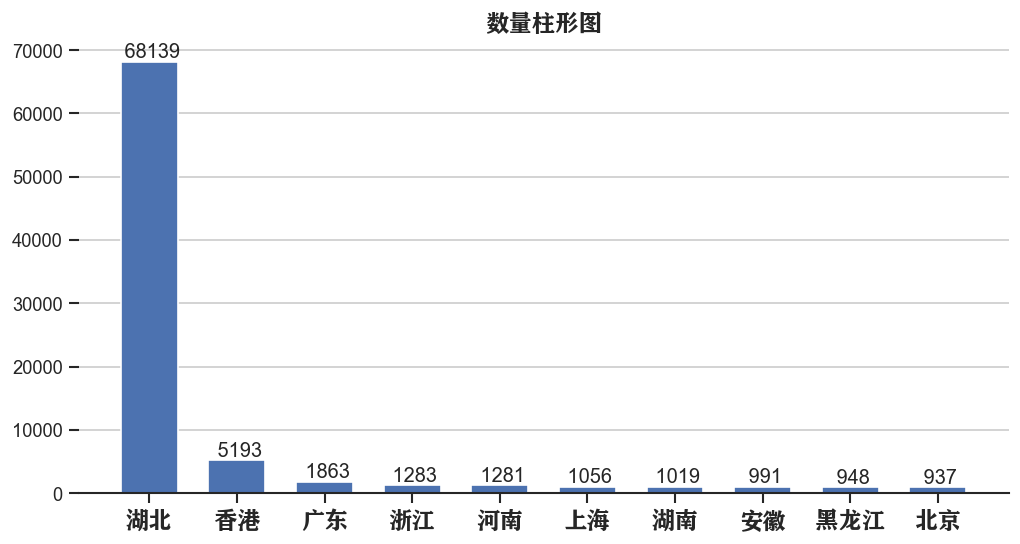

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Windows\Fonts\方正粗黑宋简体.ttf',size=14) 


#画柱形图
today_province_top10=today_province.sort_values(by="total_confirm",ascending=False)[:10
]
sns.set(style="ticks")
fig,ax=plt.subplots(figsize=(10,5))
plt.bar(today_province_top10["name"],today_province_top10["total_confirm"],color="b",width=0.65)
ax.yaxis.grid(True, which='major') # x坐标轴的网格使用主刻度
for a,b in zip(today_province_top10["name"],today_province_top10["total_confirm"]):
 ax.text(a, b+0.05," %i" % b, ha="center", va= "bottom",fontsize=12)
for item in ['top', 'right', 'left']:
 ax.spines[item].set_visible(False) #去掉边框
 
plt.title("数量柱形图",fontproperties=myfont)
plt.xticks(today_province_top10["name"],fontproperties=myfont)
plt.show()

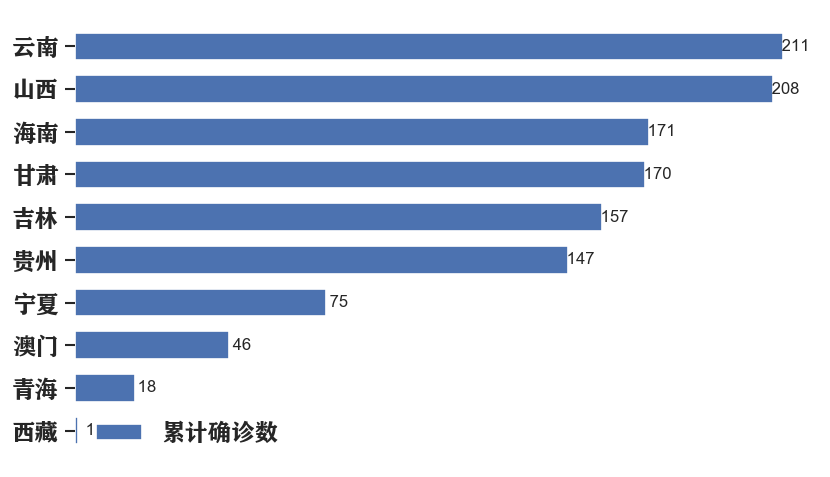

In [47]:
#数据类别较多、轴文字较多的条形图
today_province_top10=today_province.sort_values(by="total_confirm",ascending=True)[:10]
fig,ax=plt.subplots(figsize=(8,5))
#df=df.sort_values(by="total_confirm",ascending=True)
plt.barh(today_province_top10["name"],today_province_top10["total_confirm"],color="b",height=0.65,label="累计确诊数")
plt.xticks([])
plt.yticks(today_province_top10["name"],fontproperties=myfont)
for a,b in zip(today_province_top10["name"],today_province_top10["total_confirm"]):
 ax.text( b+3,a," %i" % b, ha="center", va= "center",fontsize=10)
for item in ['top', 'right', 'left',"bottom"]:
 ax.spines[item].set_visible(False) #去掉边框
plt.grid(False)
plt.legend(frameon=False,prop=myfont)
plt.show()

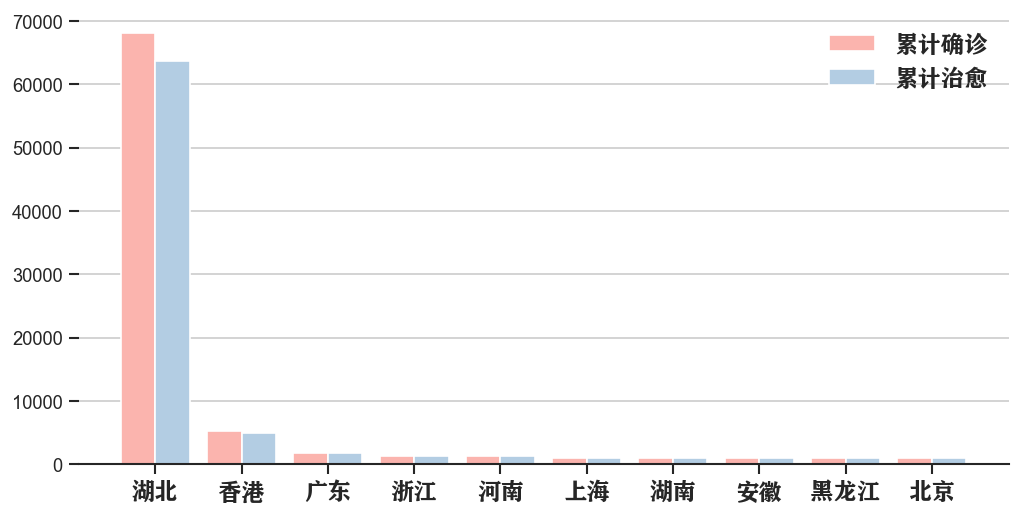

In [48]:
#分组条形图（使用色相划分）
import numpy as np
today_province_top10=today_province.sort_values(by="total_confirm",ascending=False)[:10
]
sns.set(style="ticks",palette="Pastel1")
index=np.arange(len(today_province_top10))
fig,ax=plt.subplots(figsize=(10,5))
plt.bar(index, today_province_top10["total_confirm"],label="累计确诊",width=0.4)
plt.bar(index+0.4, today_province_top10["total_heal"],label="累计治愈",width=0.4)
plt.xticks(index+0.2,today_province_top10["name"],fontproperties=myfont)
ax.yaxis.grid(True) # x坐标轴的网格使用主刻度
for item in ['top', 'right', 'left']:
 ax.spines[item].set_visible(False) #去掉边框
plt.legend(loc='best',frameon=False,prop=myfont)
plt.show()

In [49]:
#湖北数据提取
pd.DataFrame(data_HuBei).head() # 直接提取数据效果并不理想

,today,total,extData,name,id,lastUpdateTime,children
0,"{'confirm': 0, 'suspect': None, 'heal': None, ...","{'confirm': 50340, 'suspect': 0, 'heal': 46471...",{},武汉,420100,2020-10-13 00:00:24,[]
1,"{'confirm': 0, 'suspect': None, 'heal': None, ...","{'confirm': 3518, 'suspect': 0, 'heal': 3389, ...",{},孝感,420900,2020-10-13 00:00:24,[]
2,"{'confirm': 0, 'suspect': None, 'heal': None, ...","{'confirm': 2907, 'suspect': 0, 'heal': 2782, ...",{},黄冈,421100,2020-10-13 00:00:24,[]
3,"{'confirm': 0, 'suspect': None, 'heal': None, ...","{'confirm': 1580, 'suspect': 0, 'heal': 1528, ...",{},荆州,421000,2020-10-13 00:00:24,[]
4,"{'confirm': 0, 'suspect': None, 'heal': None, ...","{'confirm': 1394, 'suspect': 0, 'heal': 1335, ...",{},鄂州,420700,2020-10-13 00:00:24,[]


In [50]:
# 获取id、lastUpdateTime、name
info_Hubei= pd.DataFrame(data_HuBei)[['id','lastUpdateTime','name']]
info_Hubei.head()

,id,lastUpdateTime,name
0,420100,2020-10-13 00:00:24,武汉
1,420900,2020-10-13 00:00:24,孝感
2,421100,2020-10-13 00:00:24,黄冈
3,421000,2020-10-13 00:00:24,荆州
4,420700,2020-10-13 00:00:24,鄂州


In [51]:
# 获取today中的数据
today_data_Hubei = pd.DataFrame([Hubei['today'] for Hubei in data_HuBei ])
today_data_Hubei.head()

,confirm,suspect,heal,dead,severe,storeConfirm
0,0,None,NaN,NaN,None,None
1,0,None,NaN,NaN,None,None
2,0,None,NaN,NaN,None,None
3,0,None,NaN,NaN,None,None
4,0,None,NaN,NaN,None,None


In [52]:
today_data_Hubei.shape
['Hubei_today_'+i for i in today_data_Hubei.columns]

['Hubei_today_confirm',
 'Hubei_today_suspect',
 'Hubei_today_heal',
 'Hubei_today_dead',
 'Hubei_today_severe',
 'Hubei_today_storeConfirm']

In [53]:
today_data_Hubei.columns = ['Hubei_today_'+i for i in today_data_Hubei.columns] # 由于today中键名和total键名相同，因此需要修改列名称
today_data_Hubei.head()

,Hubei_today_confirm,Hubei_today_suspect,Hubei_today_heal,Hubei_today_dead,Hubei_today_severe,Hubei_today_storeConfirm
0,0,None,NaN,NaN,None,None
1,0,None,NaN,NaN,None,None
2,0,None,NaN,NaN,None,None
3,0,None,NaN,NaN,None,None
4,0,None,NaN,NaN,None,None


In [54]:
# 获取total中的数据
total_data_Hubei = pd.DataFrame([HuBei['total'] for HuBei in data_HuBei ])
total_data_Hubei.columns = ['total_'+i for i in total_data_Hubei.columns]
total_data_Hubei.head()

,total_confirm,total_suspect,total_heal,total_dead,total_severe
0,50340,0,46471,3869,0
1,3518,0,3389,129,0
2,2907,0,2782,125,0
3,1580,0,1528,52,0
4,1394,0,1335,59,0


In [55]:
Today_Hubei = get_data(data_HuBei,['id','lastUpdateTime','name'])
Today_Hubei.head()

,id,lastUpdateTime,name,total_confirm,total_suspect,total_heal,total_dead,total_severe,today_confirm,today_suspect,today_heal,today_dead,today_severe,today_storeConfirm
0,420100,2020-10-13 00:00:24,武汉,50340,0,46471,3869,0,0,None,NaN,NaN,None,None
1,420900,2020-10-13 00:00:24,孝感,3518,0,3389,129,0,0,None,NaN,NaN,None,None
2,421100,2020-10-13 00:00:24,黄冈,2907,0,2782,125,0,0,None,NaN,NaN,None,None
3,421000,2020-10-13 00:00:24,荆州,1580,0,1528,52,0,0,None,NaN,NaN,None,None
4,420700,2020-10-13 00:00:24,鄂州,1394,0,1335,59,0,0,None,NaN,NaN,None,None


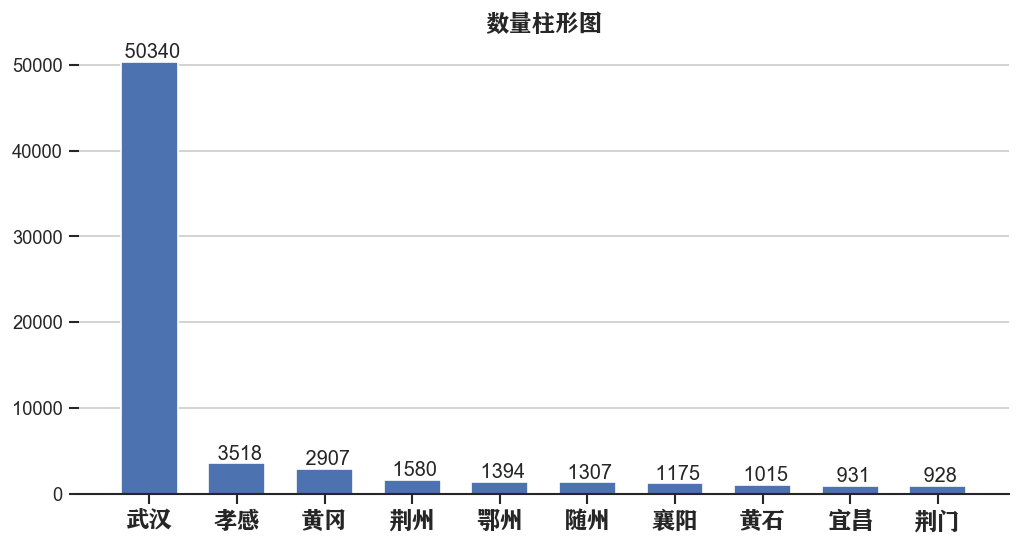

In [56]:
#湖北各市柱形图
today_hubei_top10=Today_Hubei.sort_values(by="total_confirm",ascending=False)[:10]
sns.set(style="ticks")
fig,ax=plt.subplots(figsize=(10,5))
plt.bar(today_hubei_top10["name"],today_hubei_top10["total_confirm"],color="b",width=0.65)
ax.yaxis.grid(True, which='major') # x坐标轴的网格使用主刻度
for a,b in zip(today_hubei_top10["name"],today_hubei_top10["total_confirm"]):
 ax.text(a, b+0.05," %i" % b, ha="center", va= "bottom",fontsize=12)
for item in ['top', 'right', 'left']:
 ax.spines[item].set_visible(False) #去掉边框
 
plt.title("数量柱形图",fontproperties=myfont)
plt.xticks(today_hubei_top10["name"],fontproperties=myfont)
# plt.savefig('barchar6.png', dpi=1000, transparent=True)
plt.show()

In [57]:
time.strftime('%Y_%m_%d',time.localtime(time.time()))
'2020_03_25'
save_data(Today_Hubei ,'Today_Hubei')

Today_Hubei_2020_10_13.csv 保存成功！


In [58]:
areaTree = data['areaTree'] # 取出地区
type(areaTree)

list

In [59]:
pd.DataFrame(areaTree).head() # 直接提取数据效果并不理想

,today,total,extData,name,id,lastUpdateTime,children
0,"{'confirm': 1297, 'suspect': None, 'heal': 0, ...","{'confirm': 32556, 'suspect': 0, 'heal': 5032,...",{},突尼斯,9577772,2020-10-13 00:00:16,[]
1,"{'confirm': 67, 'suspect': None, 'heal': 0, 'd...","{'confirm': 34854, 'suspect': 0, 'heal': 15913...",{},塞尔维亚,9507896,2020-10-13 00:00:16,[]
2,"{'confirm': 47, 'suspect': None, 'heal': 15, '...","{'confirm': 91358, 'suspect': 0, 'heal': 86170...",{'noSymptom': 395},中国,0,2020-10-13 08:35:33,"[{'today': {'confirm': 0, 'suspect': None, 'he..."
3,"{'confirm': 267, 'suspect': None, 'heal': 0, '...","{'confirm': 89652, 'suspect': 0, 'heal': 81552...",{},日本本土,1,2020-10-13 00:00:16,"[{'today': {'confirm': -1, 'suspect': None, 'h..."
4,"{'confirm': 5, 'suspect': None, 'heal': 0, 'de...","{'confirm': 3641, 'suspect': 0, 'heal': 3454, ...",{},泰国,2,2020-10-13 00:00:16,[]


In [60]:
for i in range(len(areaTree)): # 查看各国家名称和更新时间
    print(areaTree[i]['name'],areaTree[i]['lastUpdateTime'])
    if i == 5:
        break

突尼斯 2020-10-13 00:00:16
塞尔维亚 2020-10-13 00:00:16
中国 2020-10-13 08:35:33
日本本土 2020-10-13 00:00:16
泰国 2020-10-13 00:00:16
新加坡 2020-10-13 01:50:19


In [61]:
today_world = get_data(areaTree,['id','lastUpdateTime','name']) # areaTree
today_world.head()

,id,lastUpdateTime,name,total_confirm,total_suspect,total_heal,total_dead,total_severe,total_input,today_confirm,today_suspect,today_heal,today_dead,today_severe,today_storeConfirm,today_input
0,9577772,2020-10-13 00:00:16,突尼斯,32556,0,5032,478,0,0.0,1297.0,NaN,0.0,0.0,NaN,NaN,NaN
1,9507896,2020-10-13 00:00:16,塞尔维亚,34854,0,15913,765,0,0.0,67.0,NaN,0.0,0.0,NaN,NaN,NaN
2,0,2020-10-13 08:35:33,中国,91358,0,86170,4746,0,3029.0,47.0,NaN,15.0,0.0,NaN,32.0,21.0
3,1,2020-10-13 00:00:16,日本本土,89652,0,81552,1631,0,0.0,267.0,NaN,0.0,0.0,NaN,NaN,NaN
4,2,2020-10-13 00:00:16,泰国,3641,0,3454,59,0,0.0,5.0,NaN,0.0,0.0,NaN,NaN,NaN


In [49]:
save_data(today_world,'today_world')

today_world_2020_10_12.csv 保存成功！


In [62]:
data.keys()

dict_keys(['chinaTotal', 'chinaDayList', 'lastUpdateTime', 'overseaLastUpdateTime', 'areaTree'])

In [63]:
chinaDayList=data['chinaDayList']

In [64]:
chinaDayList[0]

{'date': '2020-01-13',
 'today': {'confirm': 0,
  'suspect': 0,
  'heal': 0,
  'dead': 0,
  'severe': None,
  'storeConfirm': 0,
  'input': 0},
 'total': {'confirm': 41,
  'suspect': 0,
  'heal': 0,
  'dead': 1,
  'severe': None,
  'input': 0,
  'storeConfirm': 0},
 'extData': None,
 'lastUpdateTime': None}

In [65]:
alltime_China = get_data(chinaDayList,['date','lastUpdateTime']) # 
alltime_China.head()

,date,lastUpdateTime,total_confirm,total_suspect,total_heal,total_dead,total_severe,total_input,total_storeConfirm,today_confirm,today_suspect,today_heal,today_dead,today_severe,today_storeConfirm,today_input
0,2020-01-13,None,41,0,0,1,None,0,0,0,0,0,0,None,0,0
1,2020-01-14,None,41,0,0,1,None,0,0,0,0,0,0,None,0,0
2,2020-01-15,None,41,0,5,2,None,0,0,0,0,0,0,None,0,0
3,2020-01-16,None,45,0,8,2,None,0,0,0,0,0,0,None,0,0
4,2020-01-17,None,62,0,12,2,None,0,0,0,0,0,0,None,0,0


In [54]:
save_data(today_world,'alltime_China')

alltime_China_2020_10_12.csv 保存成功！


In [66]:
url = 'https://c.m.163.com/ug/api/wuhan/app/data/list-by-area-code?areaCode=420000' # 定义数据地址
r_hubei= requests.get(url, headers=headers) # 进行请求
data_json_hubei = json.loads(r_hubei.text) # 获取json数据
data_json_hubei.keys()

dict_keys(['reqId', 'code', 'msg', 'data', 'timestamp'])

In [56]:
data_json_hubei['data']['list'][0]

{'date': '2020-01-20',
 'today': {'confirm': 0,
  'suspect': 0,
  'heal': 0,
  'dead': 0,
  'severe': None,
  'storeConfirm': 0,
  'input': 0},
 'total': {'confirm': 270,
  'suspect': 0,
  'heal': 25,
  'dead': 6,
  'severe': None,
  'input': 0,
  'storeConfirm': 239},
 'extData': None,
 'lastUpdateTime': None}

In [67]:
data_test = get_data(data_json_hubei['data']['list'],['date']) 
data_test['name'] = '湖北省'
data_test.head()

,date,total_confirm,total_suspect,total_heal,total_dead,total_severe,total_input,total_storeConfirm,today_confirm,today_suspect,today_heal,today_dead,today_severe,today_storeConfirm,today_input,name
0,2020-01-20,270,0,25,6,None,0,239,0,0,0,0,None,0,0,湖北省
1,2020-01-21,375,0,28,9,None,0,338,105,0,3,3,None,0,0,湖北省
2,2020-01-22,444,0,28,17,None,0,399,69,0,0,8,None,0,0,湖北省
3,2020-01-23,549,0,31,24,None,0,494,105,0,3,7,None,0,0,湖北省
4,2020-01-24,729,0,32,39,None,0,658,180,0,1,15,None,0,0,湖北省


In [68]:
today_province[['id','name']].head() # 输出前五行

,id,name
0,420000,湖北
1,810000,香港
2,440000,广东
3,330000,浙江
4,410000,河南


In [69]:
province_dict = { num:name for num,name in zip(today_province['id'],today_province['name']) } # zip

In [70]:
# 查看前五个内容
count = 0
for i in province_dict:
    print(i,province_dict[i])
    count += 1
    if count == 5:
        break

420000 湖北
810000 香港
440000 广东
330000 浙江
410000 河南


In [74]:
start = time.time()
for province_id in province_dict: # 遍历各省编号
 
 #try:
  #按照省编号访问每个省的数据地址，并获取json数据
    url = 'https://c.m.163.com/ug/api/wuhan/app/data/list-by-area-code?areaCode='+province_id
    r = requests.get(url, headers=headers)
    data_json = json.loads(r.text)
 
 # 提取各省数据，然后写入各省名称
    province_data = get_data(data_json['data']['list'],['date'])
    province_data['name'] = province_dict[province_id]
 
 # 合并数据
    if province_id == '420000':
        alltime_province = province_data
    else:
            alltime_province = pd.concat([alltime_province,province_data])
    print('-'*20,province_dict[province_id],'成功',
          province_data.shape,alltime_province.shape,
          ',累计耗时:',round(time.time()-start),'-'*20)
 
 # 设置延迟等待
    time.sleep(10)
    
 except:
    print('-'*20,province_dict[province_id],'wrong','-'*20)

-------------------- 湖北 成功 (267, 16) (267, 16) ,累计耗时: 1 --------------------
-------------------- 香港 成功 (267, 16) (534, 16) ,累计耗时: 12 --------------------
-------------------- 广东 成功 (265, 16) (799, 16) ,累计耗时: 22 --------------------
-------------------- 浙江 成功 (263, 16) (1062, 16) ,累计耗时: 33 --------------------
-------------------- 河南 成功 (265, 16) (1327, 16) ,累计耗时: 43 --------------------
-------------------- 上海 成功 (251, 16) (1578, 16) ,累计耗时: 54 --------------------
-------------------- 湖南 成功 (264, 16) (1842, 16) ,累计耗时: 65 --------------------
-------------------- 安徽 成功 (264, 16) (2106, 16) ,累计耗时: 75 --------------------
-------------------- 黑龙江 成功 (256, 16) (2362, 16) ,累计耗时: 85 --------------------
-------------------- 北京 成功 (259, 16) (2621, 16) ,累计耗时: 96 --------------------
-------------------- 江西 成功 (265, 16) (2886, 16) ,累计耗时: 107 --------------------
-------------------- 新疆 成功 (267, 16) (3153, 16) ,累计耗时: 117 --------------------
-------------------- 山东 成功 (259, 16) (3412, 16) ,累计耗时

In [71]:
url_italy = 'https://c.m.163.com/ug/api/wuhan/app/data/list-by-area-code?areaCode=15' 
# 意大利的数据地址
r = requests.get(url_italy, headers=headers) # 进行访问
italy_json = json.loads(r.text) # 导出json数据

In [72]:
italy_json.keys()
italy_json['data']['list'][0] # 查看数据内容

{'date': '2020-01-31',
 'today': {'confirm': 2,
  'suspect': 0,
  'heal': 0,
  'dead': 0,
  'severe': None,
  'storeConfirm': None},
 'total': {'confirm': 2,
  'suspect': 0,
  'heal': 0,
  'dead': 0,
  'severe': 0,
  'input': 0},
 'extData': None,
 'lastUpdateTime': None}

In [73]:
data_italy = get_data(italy_json['data']['list'],['date']) # 生成数据
data_italy['name'] = 'Italy' # 写入意大利国家名称
data_italy.head()

,date,total_confirm,total_suspect,total_heal,total_dead,total_severe,total_input,today_confirm,today_suspect,today_heal,today_dead,today_severe,today_storeConfirm,today_input,name
0,2020-01-31,2,0,0,0,0,0,2,0.0,0,0,NaN,None,NaN,Italy
1,2020-02-01,2,0,0,0,0,0,0,0.0,0,0,NaN,None,0.0,Italy
2,2020-02-02,2,0,0,0,0,0,0,0.0,0,0,NaN,None,0.0,Italy
3,2020-02-03,2,0,0,0,0,0,0,0.0,0,0,NaN,None,0.0,Italy
4,2020-02-04,2,0,0,0,0,0,0,0.0,0,0,NaN,None,0.0,Italy


In [74]:
today_world[['id','name']].head()

,id,name
0,9577772,突尼斯
1,9507896,塞尔维亚
2,0,中国
3,1,日本本土
4,2,泰国


In [75]:
country_dict = { key:value for key,value in zip(today_world['id'],today_world['name'])}

In [76]:
# 查看前五个内容
count = 0
for i in country_dict:
    print(i,country_dict[i])
    count += 1
    if count == 5:
        break

9577772 突尼斯
9507896 塞尔维亚
0 中国
1 日本本土
2 泰国


In [77]:
start = time.time()
for country_id in country_dict: # 遍历每个国家的编号
 
 try:
 # 按照编号访问每个国家的数据地址，并获取json数据
    url = 'https://c.m.163.com/ug/api/wuhan/app/data/list-by-area-code?areaCode='+country_id 
    r = requests.get(url, headers=headers)
    json_data = json.loads(r.text)
 
 # 生成每个国家的数据
    country_data = get_data(json_data['data']['list'],['date'])
    country_data['name'] = country_dict[country_id]
 # 数据叠加
    if country_id == '9577772':
        alltime_world = country_data
    else:
        alltime_world = pd.concat([alltime_world,country_data])
 
    print('-'*20,country_dict[country_id],'成功',country_data.shape,alltime_world.shape,
          ',累计耗时:',round(time.time()-start),'-'*20)
    time.sleep(10)

 except:
    print('-'*20,country_dict[country_id],'wrong','-'*20)

-------------------- 突尼斯 成功 (207, 15) (207, 15) ,累计耗时: 1 --------------------
-------------------- 突尼斯 wrong --------------------
-------------------- 塞尔维亚 成功 (212, 15) (419, 15) ,累计耗时: 11 --------------------
-------------------- 中国 成功 (250, 15) (669, 15) ,累计耗时: 22 --------------------
-------------------- 日本本土 成功 (226, 15) (895, 15) ,累计耗时: 33 --------------------
-------------------- 泰国 成功 (223, 15) (1118, 15) ,累计耗时: 44 --------------------
-------------------- 新加坡 成功 (240, 15) (1358, 15) ,累计耗时: 55 --------------------
-------------------- 韩国 成功 (263, 15) (1621, 15) ,累计耗时: 65 --------------------
-------------------- 澳大利亚 成功 (222, 15) (1843, 15) ,累计耗时: 78 --------------------
-------------------- 德国 成功 (229, 15) (2072, 15) ,累计耗时: 88 --------------------
-------------------- 美国 成功 (234, 15) (2306, 15) ,累计耗时: 99 --------------------
-------------------- 马来西亚 成功 (226, 15) (2532, 15) ,累计耗时: 110 --------------------
-------------------- 马来西亚 wrong --------------------
--------------------

-------------------- 马里 成功 (189, 15) (16771, 15) ,累计耗时: 1076 --------------------
-------------------- 阿根廷 成功 (213, 15) (16984, 15) ,累计耗时: 1087 --------------------
-------------------- 法属波利尼西亚 成功 (36, 15) (17020, 15) ,累计耗时: 1097 --------------------
-------------------- 巴林 成功 (218, 15) (17238, 15) ,累计耗时: 1108 --------------------
-------------------- 莫桑比克 成功 (180, 15) (17418, 15) ,累计耗时: 1118 --------------------
-------------------- 喀麦隆 成功 (194, 15) (17612, 15) ,累计耗时: 1129 --------------------
-------------------- 乌干达 成功 (191, 15) (17803, 15) ,累计耗时: 1140 --------------------
-------------------- 厄立特里亚 成功 (50, 15) (17853, 15) ,累计耗时: 1151 --------------------
-------------------- 刚果（布） 成功 (175, 15) (18028, 15) ,累计耗时: 1162 --------------------
-------------------- 津巴布韦 成功 (179, 15) (18207, 15) ,累计耗时: 1172 --------------------
-------------------- 丹麦 成功 (223, 15) (18430, 15) ,累计耗时: 1183 --------------------
-------------------- 阿鲁巴 成功 (34, 15) (18464, 15) ,累计耗时: 1193 --------------------


-------------------- 哈萨克斯坦 成功 (207, 15) (32094, 15) ,累计耗时: 2283 --------------------
-------------------- 安道尔 成功 (192, 15) (32286, 15) ,累计耗时: 2294 --------------------
-------------------- 牙买加 成功 (177, 15) (32463, 15) ,累计耗时: 2304 --------------------
-------------------- 格恩西岛 成功 (29, 15) (32492, 15) ,累计耗时: 2315 --------------------
-------------------- 罗马尼亚 成功 (216, 15) (32708, 15) ,累计耗时: 2325 --------------------
-------------------- 阿曼 成功 (217, 15) (32925, 15) ,累计耗时: 2336 --------------------
-------------------- 列支敦士登 成功 (48, 15) (32973, 15) ,累计耗时: 2346 --------------------
-------------------- 马达加斯加 成功 (180, 15) (33153, 15) ,累计耗时: 2357 --------------------


In [79]:
today_world.head()

,id,lastUpdateTime,name,total_confirm,total_suspect,total_heal,total_dead,total_severe,total_input,today_confirm,today_suspect,today_heal,today_dead,today_severe,today_storeConfirm,today_input
0,9577772,2020-10-13 00:00:16,突尼斯,32556,0,5032,478,0,0.0,1297.0,NaN,0.0,0.0,NaN,NaN,NaN
1,9507896,2020-10-13 00:00:16,塞尔维亚,34854,0,15913,765,0,0.0,67.0,NaN,0.0,0.0,NaN,NaN,NaN
2,0,2020-10-13 08:35:33,中国,91358,0,86170,4746,0,3029.0,47.0,NaN,15.0,0.0,NaN,32.0,21.0
3,1,2020-10-13 00:00:16,日本本土,89652,0,81552,1631,0,0.0,267.0,NaN,0.0,0.0,NaN,NaN,NaN
4,2,2020-10-13 00:00:16,泰国,3641,0,3454,59,0,0.0,5.0,NaN,0.0,0.0,NaN,NaN,NaN


In [80]:
name_dict = {'date':'日期','name':'名称','id':'编号','lastUpdateTime':'更新时间',
 'today_confirm':'当日新增确诊','today_suspect':'当日新增疑似',
 'today_heal':'当日新增治愈','today_dead':'当日新增死亡',
 'today_severe':'当日新增重症','total_input':'累计输入',
 'today_storeConfirm':'当日现存确诊',
 'total_confirm':'累计确诊','total_suspect':'累计疑似',
 'total_heal':'累计治愈','total_dead':'累计死亡','total_severe':'累计重症','today_input':'当日输入'}
# 更改列名
today_world.rename(columns=name_dict,inplace=True) # inplace参数判断是否在原数据上进行 修改
today_world.head(3)

,编号,更新时间,名称,累计确诊,累计疑似,累计治愈,累计死亡,累计重症,累计输入,当日新增确诊,当日新增疑似,当日新增治愈,当日新增死亡,当日新增重症,当日现存确诊,当日输入
0,9577772,2020-10-13 00:00:16,突尼斯,32556,0,5032,478,0,0.0,1297.0,NaN,0.0,0.0,NaN,NaN,NaN
1,9507896,2020-10-13 00:00:16,塞尔维亚,34854,0,15913,765,0,0.0,67.0,NaN,0.0,0.0,NaN,NaN,NaN
2,0,2020-10-13 08:35:33,中国,91358,0,86170,4746,0,3029.0,47.0,NaN,15.0,0.0,NaN,32.0,21.0


In [81]:
# 查看数据基本信息
today_world.info()
# 默认只计算数值型特征的统计信息
today_world.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   编号      207 non-null    object 
 1   更新时间    207 non-null    object 
 2   名称      207 non-null    object 
 3   累计确诊    207 non-null    int64  
 4   累计疑似    207 non-null    int64  
 5   累计治愈    207 non-null    int64  
 6   累计死亡    207 non-null    int64  
 7   累计重症    207 non-null    int64  
 8   累计输入    170 non-null    float64
 9   当日新增确诊  160 non-null    float64
 10  当日新增疑似  13 non-null     float64
 11  当日新增治愈  160 non-null    float64
 12  当日新增死亡  160 non-null    float64
 13  当日新增重症  13 non-null     float64
 14  当日现存确诊  1 non-null      float64
 15  当日输入    6 non-null      float64
dtypes: float64(8), int64(5), object(3)
memory usage: 26.0+ KB


,累计确诊,累计疑似,累计治愈,累计死亡,累计重症,累计输入,当日新增确诊,当日新增疑似,当日新增治愈,当日新增死亡,当日新增重症,当日现存确诊,当日输入
count,2.070000e+02,207.0,2.070000e+02,207.000000,207.0,170.000000,160.000000,13.0,160.000000,160.0,13.0,1.0,6.000000
mean,1.832225e+05,0.0,1.366016e+05,5231.043478,0.0,17.817647,2050.750000,0.0,0.093750,0.0,0.0,32.0,3.500000
std,8.348762e+05,0.0,6.475949e+05,21499.519832,0.0,232.313695,7317.617058,0.0,1.185854,0.0,0.0,NaN,8.573214
min,1.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,32.0,0.000000
25%,5.945000e+02,0.0,2.915000e+02,13.500000,0.0,0.000000,9.750000,0.0,0.000000,0.0,0.0,32.0,0.000000
50%,9.864000e+03,0.0,6.075000e+03,146.000000,0.0,0.000000,143.500000,0.0,0.000000,0.0,0.0,32.0,0.000000
75%,8.356750e+04,0.0,4.796200e+04,1083.500000,0.0,0.000000,1023.500000,0.0,0.000000,0.0,0.0,32.0,0.000000
max,8.035368e+06,0.0,6.149535e+06,220005.000000,0.0,3029.000000,66732.000000,0.0,15.000000,0.0,0.0,32.0,21.000000


In [82]:
# 计算缺失值比例
today_world_nan = today_world.isnull().sum()/len(today_world)
# 转变为百分数
today_world_nan.apply(lambda x: format(x, '.1%'))

编号         0.0%
更新时间       0.0%
名称         0.0%
累计确诊       0.0%
累计疑似       0.0%
累计治愈       0.0%
累计死亡       0.0%
累计重症       0.0%
累计输入      17.9%
当日新增确诊    22.7%
当日新增疑似    93.7%
当日新增治愈    22.7%
当日新增死亡    22.7%
当日新增重症    93.7%
当日现存确诊    99.5%
当日输入      97.1%
dtype: object

In [83]:
# 缺失值处理
today_world['当日现存确诊'] = today_world['累计确诊']-today_world['累计治愈']-today_world[ '累计死亡']

In [84]:
# 计算缺失值比例
today_world_nan = today_world.isnull().sum()/len(today_world)
# 转变为百分数
today_world_nan.apply(lambda x: format(x, '.1%'))

编号         0.0%
更新时间       0.0%
名称         0.0%
累计确诊       0.0%
累计疑似       0.0%
累计治愈       0.0%
累计死亡       0.0%
累计重症       0.0%
累计输入      17.9%
当日新增确诊    22.7%
当日新增疑似    93.7%
当日新增治愈    22.7%
当日新增死亡    22.7%
当日新增重症    93.7%
当日现存确诊     0.0%
当日输入      97.1%
dtype: object

In [85]:
# 计算病死率,且保留两位小数
today_world['病死率'] = (today_world['累计死亡']/today_world['累计确诊']).apply(lambda x:
format(x, '.2f'))
# 将病死率数据类型转换为float
today_world['病死率'] = today_world['病死率'].astype('float')
# 根据病死率降序排序
today_world.sort_values('病死率',ascending=False,inplace=True)
# 显示病死率前十国家
today_world.head(10)

,编号,更新时间,名称,累计确诊,累计疑似,累计治愈,累计死亡,累计重症,累计输入,当日新增确诊,当日新增疑似,当日新增治愈,当日新增死亡,当日新增重症,当日现存确诊,当日输入,病死率
168,95200,2020-10-13 05:00:23,也门,2052,0,1329,596,0,0.0,1.0,NaN,0.0,0.0,NaN,127,NaN,0.29
144,95287,2020-06-15 14:48:56,圣马丁岛,77,0,61,15,0,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,0.19
16,828,2020-06-09 19:59:04,毛利亚尼亚,16,0,6,2,0,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,0.12
162,15,2020-10-13 00:00:16,意大利,359569,0,240600,36205,0,0.0,10075.0,NaN,0.0,0.0,NaN,82764,NaN,0.10
197,96745,2020-10-13 00:00:16,墨西哥,817503,0,694214,83781,0,0.0,3175.0,NaN,0.0,0.0,NaN,39508,NaN,0.10
33,80902,2020-06-12 17:02:32,蒙特塞拉特,11,0,10,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.09
151,89665,2020-06-15 13:49:44,瓜德罗普,171,0,157,14,0,NaN,NaN,0.0,NaN,NaN,0.0,0,NaN,0.08
125,95303,2020-06-15 13:51:31,圭亚那,159,0,99,12,0,NaN,NaN,0.0,NaN,NaN,0.0,48,NaN,0.08
28,875097,2020-06-12 17:06:26,美属维尔京群岛,72,0,46,6,0,NaN,NaN,NaN,NaN,NaN,NaN,20,NaN,0.08
61,95102,2020-10-13 03:45:19,厄瓜多尔,147315,0,128134,12218,0,0.0,205.0,NaN,0.0,0.0,NaN,6963,NaN,0.08


In [86]:
# 将国家名称设为索引
today_world.set_index('名称',inplace=True)
today_world.head(3)

,编号,更新时间,累计确诊,累计疑似,累计治愈,累计死亡,累计重症,累计输入,当日新增确诊,当日新增疑似,当日新增治愈,当日新增死亡,当日新增重症,当日现存确诊,当日输入,病死率
名称,,,,,,,,,,,,,,,,
也门,95200,2020-10-13 05:00:23,2052,0,1329,596,0,0.0,1.0,NaN,0.0,0.0,NaN,127,NaN,0.29
圣马丁岛,95287,2020-06-15 14:48:56,77,0,61,15,0,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,0.19
毛利亚尼亚,828,2020-06-09 19:59:04,16,0,6,2,0,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,0.12


In [87]:
# 查看当前累计确诊人数前十国家
world_top10 = today_world.sort_values(['累计确诊'],ascending=False)[:10]
world_top10 = world_top10[['累计确诊','累计死亡','病死率']]
world_top10

,累计确诊,累计死亡,病死率
名称,,,
美国,8035368,220005,0.03
印度,7120538,109150,0.02
巴西,5094979,150488,0.03
俄罗斯,1305093,22594,0.02
哥伦比亚,919083,27985,0.03
西班牙,918223,33124,0.04
阿根廷,903730,24186,0.03
秘鲁,849371,33305,0.04
墨西哥,817503,83781,0.10


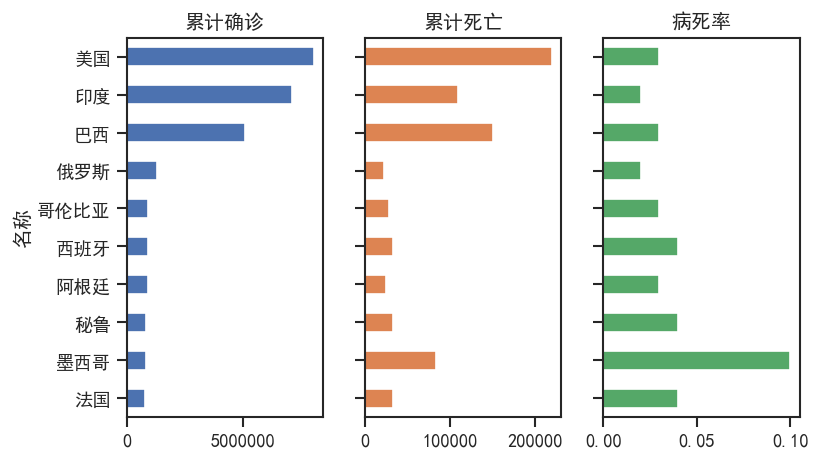

In [88]:
# 导入matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #正常显示中文
plt.rcParams['figure.dpi'] = 120 #设置所有图片的清晰度
# 绘制条形图
world_top10.sort_values('累计确诊').plot.barh(subplots=True,layout=(1,3),sharex=False,
                                          figsize=(7,4),legend=False,sharey=True)
plt.tight_layout() #调整子图间距
plt.show()

In [91]:
# 查看当前累计确诊人数前十国家
world_top5 = today_world.sort_values(['累计确诊'],ascending=False)[:5]
world_top5= world_top5[['累计确诊','累计死亡','累计治愈']]
world_top5

,累计确诊,累计死亡,累计治愈
名称,,,
美国,8035368,220005,5174134
印度,7120538,109150,6149535
巴西,5094979,150488,4526393
俄罗斯,1305093,22594,1019905
哥伦比亚,919083,27985,798396


In [92]:
# 中国国内疫情更改列名
today_province.rename(columns=name_dict,inplace=True) # inplace参数是否在原对象基础上 进行修改
today_province.head()

,编号,更新时间,名称,累计确诊,累计疑似,累计治愈,累计死亡,累计重症,累计输入,total_newConfirm,total_newDead,total_newHeal,当日新增确诊,当日新增疑似,当日新增治愈,当日新增死亡,当日新增重症,当日现存确诊
0,420000,2020-10-13 00:00:24,湖北,68139,0,63627,4512,0,0,NaN,NaN,NaN,0,None,0,0,None,0
1,810000,2020-10-13 00:00:24,香港,5193,0,4921,105,0,0,NaN,NaN,NaN,7,None,7,0,None,11
2,440000,2020-10-13 08:35:34,广东,1863,0,1825,8,0,0,NaN,NaN,NaN,3,None,0,0,None,3
3,330000,2020-10-13 00:00:24,浙江,1283,0,1272,1,0,0,NaN,NaN,NaN,0,None,0,0,None,0
4,410000,2020-10-13 00:00:24,河南,1281,0,1255,22,0,0,NaN,NaN,NaN,0,None,0,0,None,0


In [93]:
# 查看数据基本信息
today_province.info()
# 查看数值型特征的统计量
today_province.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   编号                34 non-null     object 
 1   更新时间              34 non-null     object 
 2   名称                34 non-null     object 
 3   累计确诊              34 non-null     int64  
 4   累计疑似              34 non-null     int64  
 5   累计治愈              34 non-null     int64  
 6   累计死亡              34 non-null     int64  
 7   累计重症              34 non-null     int64  
 8   累计输入              34 non-null     int64  
 9   total_newConfirm  1 non-null      float64
 10  total_newDead     1 non-null      float64
 11  total_newHeal     1 non-null      float64
 12  当日新增确诊            34 non-null     int64  
 13  当日新增疑似            0 non-null      object 
 14  当日新增治愈            34 non-null     int64  
 15  当日新增死亡            34 non-null     int64  
 16  当日新增重症            0 non-null      object 
 17 

,累计确诊,累计疑似,累计治愈,累计死亡,累计重症,累计输入,total_newConfirm,total_newDead,total_newHeal,当日新增确诊,当日新增治愈,当日新增死亡,当日现存确诊
count,34.000000,34.0,34.000000,34.000000,34.0,34.0,1.0,1.0,1.0,34.000000,34.000000,34.0,34.000000
mean,2687.000000,0.0,2534.411765,139.588235,0.0,0.0,343.0,0.0,342.0,1.058824,0.617647,0.0,0.764706
std,11600.718512,0.0,10829.506148,772.792109,0.0,0.0,NaN,NaN,NaN,1.857681,1.557284,0.0,2.323253
min,1.000000,0.0,1.000000,0.000000,0.0,0.0,343.0,0.0,342.0,0.000000,0.000000,0.0,-2.000000
25%,208.750000,0.0,200.750000,1.000000,0.0,0.0,343.0,0.0,342.0,0.000000,0.000000,0.0,0.000000
50%,478.500000,0.0,445.500000,3.000000,0.0,0.0,343.0,0.0,342.0,0.000000,0.000000,0.0,0.000000
75%,945.250000,0.0,934.750000,6.750000,0.0,0.0,343.0,0.0,342.0,1.000000,0.000000,0.0,0.000000
max,68139.000000,0.0,63627.000000,4512.000000,0.0,0.0,343.0,0.0,342.0,7.000000,7.000000,0.0,11.000000


In [95]:
# 计算各省当日现存确诊人数
today_province['当日现存确诊'] = today_province['累计确诊']-today_province['累计治愈']-today_province['累计死亡']
# 将各省名称设置为索引
today_province.set_index('名称',inplace=True)
today_province.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, 湖北 to 西藏
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   编号                34 non-null     object 
 1   更新时间              34 non-null     object 
 2   累计确诊              34 non-null     int64  
 3   累计疑似              34 non-null     int64  
 4   累计治愈              34 non-null     int64  
 5   累计死亡              34 non-null     int64  
 6   累计重症              34 non-null     int64  
 7   累计输入              34 non-null     int64  
 8   total_newConfirm  1 non-null      float64
 9   total_newDead     1 non-null      float64
 10  total_newHeal     1 non-null      float64
 11  当日新增确诊            34 non-null     int64  
 12  当日新增疑似            0 non-null      object 
 13  当日新增治愈            34 non-null     int64  
 14  当日新增死亡            34 non-null     int64  
 15  当日新增重症            0 non-null      object 
 16  当日现存确诊            34 non-null     int64  
dtypes: 

In [96]:
# 查看全国新增确诊top10的地区
new_top6 = today_province['当日新增确诊'].sort_values(ascending=False)[:10]
new_top6

名称
香港     7
山东     6
上海     5
辽宁     4
广东     3
山西     2
河北     2
台湾     2
四川     1
内蒙古    1
Name: 当日新增确诊, dtype: int64

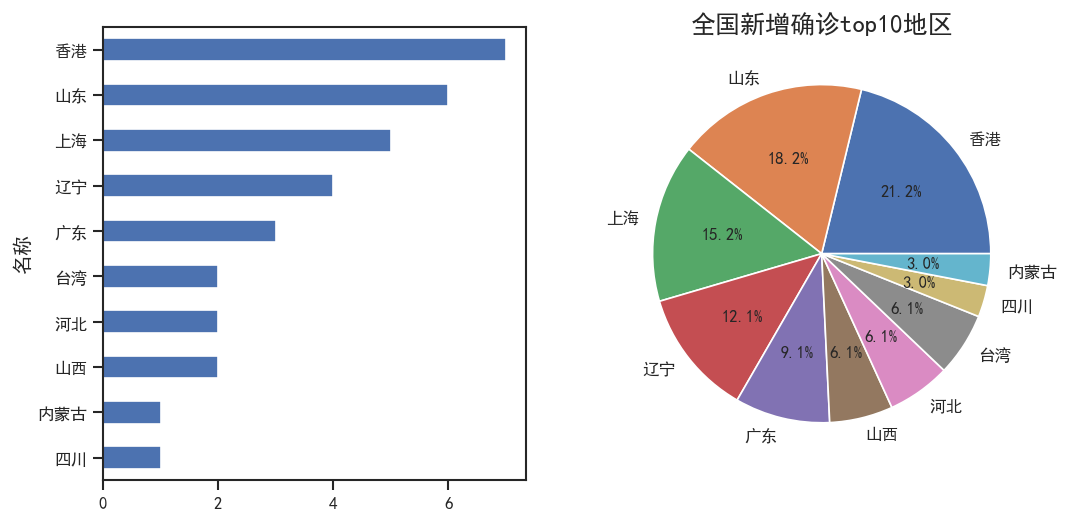

In [97]:
# 绘制条形图和饼图
fig,ax = plt.subplots(1,2,figsize=(10,5))
new_top6.sort_values(ascending=True).plot.barh(fontsize=10,ax=ax[0])
new_top6.plot.pie(autopct='%.1f%%',fontsize=10,ax=ax[1])
plt.ylabel('')
plt.title('全国新增确诊top10地区',size=15)
plt.show()

In [98]:
# 查看全国现存确诊人数top10的省市
store_top10 = today_province['当日现存确诊'].sort_values(ascending=False)[:10]
store_top10

名称
香港    167
上海     64
四川     43
台湾     33
广东     30
陕西     27
福建     13
浙江     10
云南      9
辽宁      9
Name: 当日现存确诊, dtype: int64

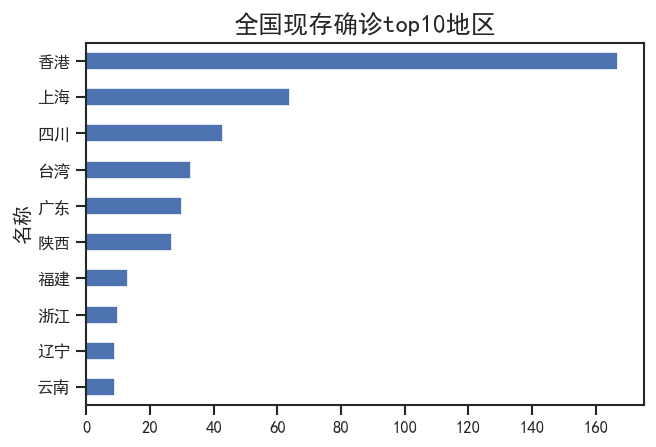

In [99]:
# 绘制条形图
store_top10.sort_values(ascending=True).plot.barh(fontsize=10)
plt.title('全国现存确诊top10地区',size=15)
plt.show()

In [100]:
# 更改列名
alltime_China.rename(columns=name_dict,inplace=True)
alltime_China.head()

,日期,更新时间,累计确诊,累计疑似,累计治愈,累计死亡,累计重症,累计输入,total_storeConfirm,当日新增确诊,当日新增疑似,当日新增治愈,当日新增死亡,当日新增重症,当日现存确诊,当日输入
0,2020-01-13,None,41,0,0,1,None,0,0,0,0,0,0,None,0,0
1,2020-01-14,None,41,0,0,1,None,0,0,0,0,0,0,None,0,0
2,2020-01-15,None,41,0,5,2,None,0,0,0,0,0,0,None,0,0
3,2020-01-16,None,45,0,8,2,None,0,0,0,0,0,0,None,0,0
4,2020-01-17,None,62,0,12,2,None,0,0,0,0,0,0,None,0,0


In [101]:
alltime_China.info()
alltime_China.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   日期                  273 non-null    object
 1   更新时间                0 non-null      object
 2   累计确诊                273 non-null    int64 
 3   累计疑似                273 non-null    int64 
 4   累计治愈                273 non-null    int64 
 5   累计死亡                273 non-null    int64 
 6   累计重症                0 non-null      object
 7   累计输入                273 non-null    int64 
 8   total_storeConfirm  273 non-null    int64 
 9   当日新增确诊              273 non-null    int64 
 10  当日新增疑似              273 non-null    int64 
 11  当日新增治愈              273 non-null    int64 
 12  当日新增死亡              273 non-null    int64 
 13  当日新增重症              0 non-null      object
 14  当日现存确诊              273 non-null    int64 
 15  当日输入                273 non-null    int64 
dtypes: int64(12), object(4)
me

,累计确诊,累计疑似,累计治愈,累计死亡,累计输入,total_storeConfirm,当日新增确诊,当日新增疑似,当日新增治愈,当日新增死亡,当日现存确诊,当日输入
count,273.000000,273.0,273.000000,273.000000,273.000000,273.00000,273.000000,273.000000,273.0,273.0,273.0,273.000000
mean,77246.326007,0.0,66822.271062,3786.948718,1477.699634,6631.29304,337.300366,360.047619,0.0,0.0,0.0,11.029304
std,23652.418675,0.0,28231.424775,1456.715743,974.375391,13852.09410,1168.054238,1073.918057,0.0,0.0,0.0,15.626590
min,41.000000,0.0,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000
25%,81498.000000,0.0,72382.000000,3267.000000,314.000000,386.00000,16.000000,0.000000,0.0,0.0,0.0,1.000000
50%,84547.000000,0.0,79791.000000,4645.000000,1734.000000,836.00000,34.000000,2.000000,0.0,0.0,0.0,6.000000
75%,88682.000000,0.0,81675.000000,4683.000000,2103.000000,2556.00000,114.000000,26.000000,0.0,0.0,0.0,14.000000
max,91333.000000,0.0,86167.000000,4746.000000,3029.000000,58097.00000,15153.000000,5328.000000,0.0,0.0,0.0,98.000000


In [102]:
# 缺失值处理
# 计算当日现存确诊人数
alltime_China['当日现存确诊'] = alltime_China['累计确诊']-alltime_China['累计治愈']-alltime_China['累计死亡']
# 删除更新时间一列
alltime_China.drop(['更新时间','当日新增重症'],axis=1,inplace=True)
alltime_China.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   日期                  273 non-null    object
 1   累计确诊                273 non-null    int64 
 2   累计疑似                273 non-null    int64 
 3   累计治愈                273 non-null    int64 
 4   累计死亡                273 non-null    int64 
 5   累计重症                0 non-null      object
 6   累计输入                273 non-null    int64 
 7   total_storeConfirm  273 non-null    int64 
 8   当日新增确诊              273 non-null    int64 
 9   当日新增疑似              273 non-null    int64 
 10  当日新增治愈              273 non-null    int64 
 11  当日新增死亡              273 non-null    int64 
 12  当日现存确诊              273 non-null    int64 
 13  当日输入                273 non-null    int64 
dtypes: int64(12), object(2)
memory usage: 30.0+ KB


In [104]:
# 将日期改成datetime格式
alltime_China['日期'] = pd.to_datetime(alltime_China['日期'])
# 设置日期为索引
alltime_China.set_index('日期',inplace=True) # 也可使用pd.read_csv("./input/alltime_China_2020_03_27.csv",parse_dates=['date'],index_col='date')
alltime_China.index

DatetimeIndex(['2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
               '2020-01-21', '2020-01-22',
               ...
               '2020-10-02', '2020-10-03', '2020-10-04', '2020-10-05',
               '2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09',
               '2020-10-10', '2020-10-11'],
              dtype='datetime64[ns]', name='日期', length=273, freq=None)

In [105]:
# 举例
alltime_China.loc['2020-01']

,累计确诊,累计疑似,累计治愈,累计死亡,累计重症,累计输入,total_storeConfirm,当日新增确诊,当日新增疑似,当日新增治愈,当日新增死亡,当日现存确诊,当日输入
日期,,,,,,,,,,,,,
2020-01-13,41,0,0,1,None,0,0,0,0,0,0,40,0
2020-01-14,41,0,0,1,None,0,0,0,0,0,0,40,0
2020-01-15,41,0,5,2,None,0,0,0,0,0,0,34,0
2020-01-16,45,0,8,2,None,0,0,0,0,0,0,35,0
2020-01-17,62,0,12,2,None,0,0,0,0,0,0,48,0
2020-01-18,198,0,17,3,None,0,0,0,0,0,0,178,0
2020-01-19,275,0,18,4,None,0,0,0,0,0,0,253,0
2020-01-20,291,0,25,6,None,0,291,77,27,0,0,260,0
2020-01-21,440,0,25,9,None,0,431,149,53,0,0,406,0


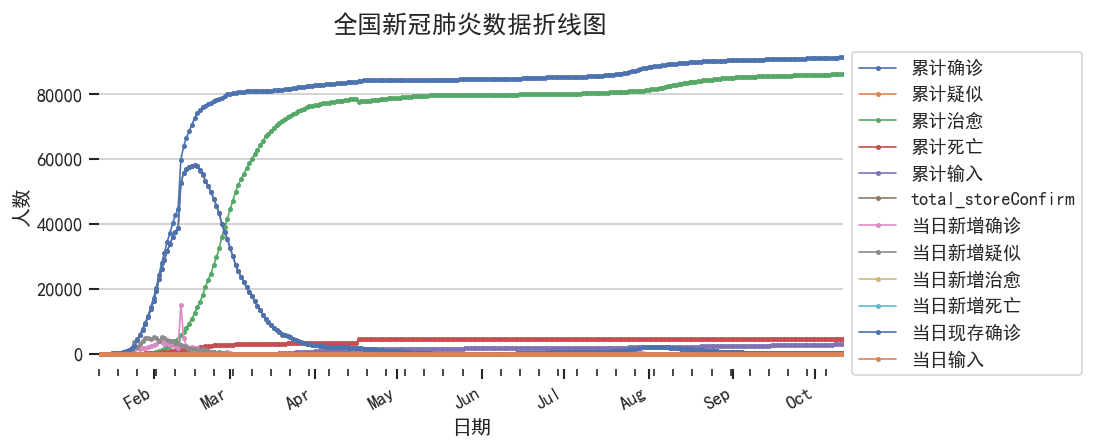

In [106]:
# 时间序列数据绘制折线图
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import datetime
fig, ax = plt.subplots(figsize=(8,4))
alltime_China.plot(marker='o',ms=2,lw=1,ax=ax)
ax.xaxis.set_major_locator(dates.MonthLocator()) #设置间距
ax.xaxis.set_major_formatter(dates.DateFormatter('%b')) #设置日期格式
fig.autofmt_xdate() #自动调整日期倾斜
# 图例位置调整
plt.legend(bbox_to_anchor = [1,1])
plt.title('全国新冠肺炎数据折线图',size=15)
plt.ylabel('人数')
plt.grid(axis='y')
plt.box(False)
plt.show()

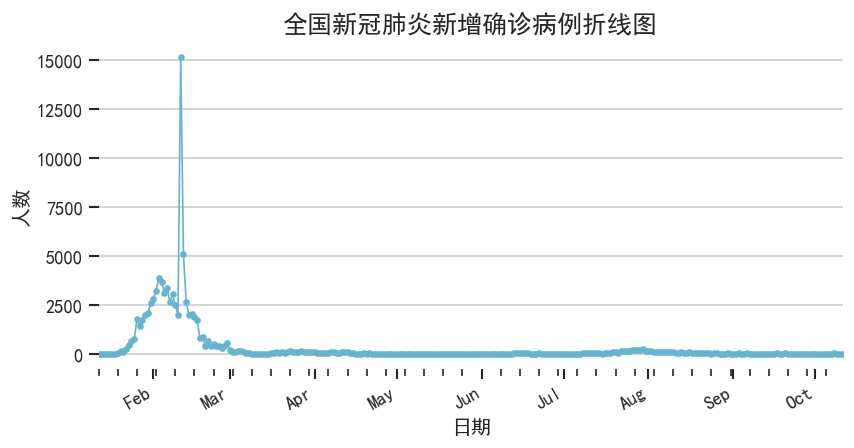

In [107]:
# 时间序列数据绘制折线图
fig, ax = plt.subplots(figsize=(8,4))
alltime_China['当日新增确诊'].plot(ax=ax, style='-',lw=1,color='c',marker='o',ms=3)
ax.xaxis.set_major_locator(dates.MonthLocator()) #设置间距
ax.xaxis.set_major_formatter(dates.DateFormatter('%b')) #设置日期格式
fig.autofmt_xdate() #自动调整日期倾斜
plt.title('全国新冠肺炎新增确诊病例折线图',size=15)
plt.ylabel('人数')
plt.grid(axis='y')
plt.box(False)
plt.show()

In [108]:
# 世界历史更改列名
alltime_world.rename(columns=name_dict,inplace=True)
alltime_world.head()

,日期,累计确诊,累计疑似,累计治愈,累计死亡,累计重症,累计输入,当日新增确诊,当日新增疑似,当日新增治愈,当日新增死亡,当日新增重症,当日现存确诊,当日输入,名称
0,2020-03-03,1,0,0,0,0,0,1,0.0,0,0,NaN,None,NaN,突尼斯
1,2020-03-08,2,0,0,0,0,0,1,0.0,0,0,0.0,None,0.0,突尼斯
2,2020-03-09,5,0,0,0,0,0,3,0.0,0,0,0.0,None,0.0,突尼斯
3,2020-03-11,7,0,0,0,0,0,2,0.0,0,0,0.0,None,0.0,突尼斯
4,2020-03-12,13,0,0,0,0,0,6,0.0,0,0,0.0,None,0.0,突尼斯


In [109]:
alltime_world.info()
alltime_world.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33153 entries, 0 to 179
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   日期      33153 non-null  object 
 1   累计确诊    33153 non-null  int64  
 2   累计疑似    33153 non-null  int64  
 3   累计治愈    33153 non-null  int64  
 4   累计死亡    33153 non-null  int64  
 5   累计重症    33153 non-null  int64  
 6   累计输入    33153 non-null  int64  
 7   当日新增确诊  33153 non-null  int64  
 8   当日新增疑似  12909 non-null  float64
 9   当日新增治愈  33153 non-null  int64  
 10  当日新增死亡  33153 non-null  int64  
 11  当日新增重症  12509 non-null  float64
 12  当日现存确诊  0 non-null      object 
 13  当日输入    32957 non-null  float64
 14  名称      33153 non-null  object 
dtypes: float64(3), int64(9), object(3)
memory usage: 4.0+ MB


,累计确诊,累计疑似,累计治愈,累计死亡,累计重症,累计输入,当日新增确诊,当日新增疑似,当日新增治愈,当日新增死亡,当日新增重症,当日输入
count,3.315300e+04,33153.000000,3.315300e+04,33153.000000,33153.000000,33153.000000,33153.000000,12909.000000,33153.000000,33153.000000,12509.000000,32957.000000
mean,8.622959e+04,8.261213,5.645692e+04,3280.799023,3.337285,11.995415,1144.036558,3.528314,852.948451,32.662414,-0.581341,0.091908
std,4.535516e+05,380.953824,3.145639e+05,14462.602958,122.746629,159.856371,5875.438002,95.676476,5737.600892,168.831118,12.372097,4.238486
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-65415.000000,0.000000,-344468.000000,-6464.000000,-464.000000,-19.000000
25%,6.990000e+02,0.000000,1.780000e+02,11.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.315000e+03,0.000000,1.810000e+03,82.000000,0.000000,0.000000,50.000000,0.000000,13.000000,1.000000,0.000000,0.000000
75%,3.267600e+04,0.000000,1.591300e+04,666.000000,0.000000,0.000000,388.000000,0.000000,184.000000,7.000000,0.000000,0.000000
max,8.035368e+06,28942.000000,6.149535e+06,220005.000000,7365.000000,3029.000000,145739.000000,4008.000000,349681.000000,7057.000000,0.000000,723.000000


In [112]:
# 将日期一列数据类型变为datetime
alltime_world['日期'] = pd.to_datetime(alltime_world['日期'])
# 计算当日现存确诊
alltime_world['当日现存确诊'] = alltime_world['累计确诊']-alltime_world['累计治愈']-alltime_world['累计死亡']
alltime_world.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33153 entries, 0 to 179
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   日期      33153 non-null  datetime64[ns]
 1   累计确诊    33153 non-null  int64         
 2   累计疑似    33153 non-null  int64         
 3   累计治愈    33153 non-null  int64         
 4   累计死亡    33153 non-null  int64         
 5   累计重症    33153 non-null  int64         
 6   累计输入    33153 non-null  int64         
 7   当日新增确诊  33153 non-null  int64         
 8   当日新增疑似  12909 non-null  float64       
 9   当日新增治愈  33153 non-null  int64         
 10  当日新增死亡  33153 non-null  int64         
 11  当日新增重症  12509 non-null  float64       
 12  当日现存确诊  33153 non-null  int64         
 13  当日输入    32957 non-null  float64       
 14  名称      33153 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(10), object(1)
memory usage: 4.0+ MB


In [113]:
# 查看唯一值,可使用len()查看个数
alltime_world['名称'].unique()

array(['突尼斯', '塞尔维亚', '中国', '日本本土', '泰国', '新加坡', '韩国', '澳大利亚', '德国', '美国',
       '马来西亚', '越南', '圣巴泰勒米', '肯尼亚', '伊朗', '以色列', '毛利亚尼亚', '黎巴嫩', '克罗地亚',
       '奥地利', '瑞士', '希腊', '毛里求斯', '爱沙尼亚', '北马其顿', '白俄罗斯', '立陶宛', '阿塞拜疆',
       '美属维尔京群岛', '蒙古', '乌克兰', '波兰', '波黑', '蒙特塞拉特', '南非', '布隆迪', '南苏丹',
       '马耳他', '摩尔多瓦', '保加利亚', '孟加拉', '阿尔巴尼亚', '巴勒斯坦', '科摩罗', '阿富汗',
       '沙特阿拉伯', '新西兰', '塔吉克斯坦', '泽西岛', '叙利亚', '巴拿马', '古巴', '尼日利亚', '摩洛哥',
       '塞内加尔', '老挝', '巴哈马', '马约特岛', '斯洛文尼亚', '卢森堡', '爱尔兰', '厄瓜多尔', '捷克',
       '匈牙利', '法属圭亚那', '多哥共和国', '哥斯达黎加', '文莱', '法罗群岛', '马提尼克岛', '荷兰',
       '巴西', '洪都拉斯', '乌拉圭', '秘鲁', '智利', '格陵兰', '圣巴托洛谬岛', '马尔代夫', '委内瑞拉',
       '毛里塔尼亚', '纳米比亚', '法属留尼汪岛', '波多黎各', '加纳', '赤道几内亚', '几内亚', '卢旺达',
       '格林纳达', '斯威士兰', '坦桑尼亚', '贝宁', '刚果（金）', '中非共和国', '利比里亚', '索马里',
       '塞拉利昂', '乍得', '赞比亚', '巴巴多斯', '马里', '阿根廷', '法属波利尼西亚', '巴林', '莫桑比克',
       '喀麦隆', '乌干达', '厄立特里亚', '刚果（布）', '津巴布韦', '丹麦', '阿鲁巴', '斐济', '伯利兹',
       '缅甸', '塞浦路斯', '关岛', '科索沃', '圣皮埃尔岛和密克隆岛', '吉尔吉斯斯坦', '博

In [114]:
# 统计每天有多少国家出现疫情
alltime_world['日期'].value_counts().head(20)

2020-05-27    207
2020-06-08    207
2020-05-24    207
2020-06-11    206
2020-06-01    206
2020-06-05    206
2020-05-31    206
2020-05-30    206
2020-06-10    206
2020-05-26    205
2020-05-19    205
2020-05-14    205
2020-05-12    205
2020-06-03    205
2020-05-20    204
2020-06-06    204
2020-06-04    204
2020-05-25    204
2020-05-18    203
2020-05-11    202
Name: 日期, dtype: int64

In [115]:
# 设置日期索引
alltime_world.set_index('日期',inplace=True)
# 3月31日数据统计不完全，我们将其删除
alltime_world = alltime_world.loc[:'2020-03-31']

In [116]:
# groupby创建层次化索引
data = alltime_world.groupby(['日期','名称']).mean()
data.head()

,,累计确诊,累计疑似,累计治愈,累计死亡,累计重症,累计输入,当日新增确诊,当日新增疑似,当日新增治愈,当日新增死亡,当日新增重症,当日现存确诊,当日输入
日期,名称,,,,,,,,,,,,,
2020-01-20,韩国,1,0,0,0,0,0,1,0.0,0,0,NaN,1,NaN
2020-01-21,韩国,1,0,0,0,0,0,0,0.0,0,0,NaN,1,0.0
2020-01-22,韩国,1,0,0,0,0,0,0,0.0,0,0,NaN,1,0.0
2020-01-23,韩国,1,0,0,0,0,0,0,0.0,0,0,NaN,1,0.0
2020-01-24,韩国,2,0,0,0,0,0,1,0.0,0,0,NaN,2,0.0


In [117]:
# 提取部分数据
data_part = data.loc(axis=0)[:,['中国','日本','韩国','美国','意大利','英国','西班牙','德国']]
data_part.head()

,,累计确诊,累计疑似,累计治愈,累计死亡,累计重症,累计输入,当日新增确诊,当日新增疑似,当日新增治愈,当日新增死亡,当日新增重症,当日现存确诊,当日输入
日期,名称,,,,,,,,,,,,,
2020-01-20,韩国,1,0,0,0,0,0,1,0.0,0,0,NaN,1,NaN
2020-01-21,韩国,1,0,0,0,0,0,0,0.0,0,0,NaN,1,0.0
2020-01-22,韩国,1,0,0,0,0,0,0,0.0,0,0,NaN,1,0.0
2020-01-23,韩国,1,0,0,0,0,0,0,0.0,0,0,NaN,1,0.0
2020-01-24,韩国,2,0,0,0,0,0,1,0.0,0,0,NaN,2,0.0


In [118]:
# 将层级索引还原
data_part.reset_index('名称',inplace=True)
data_part.head()

,名称,累计确诊,累计疑似,累计治愈,累计死亡,累计重症,累计输入,当日新增确诊,当日新增疑似,当日新增治愈,当日新增死亡,当日新增重症,当日现存确诊,当日输入
日期,,,,,,,,,,,,,,
2020-01-20,韩国,1,0,0,0,0,0,1,0.0,0,0,NaN,1,NaN
2020-01-21,韩国,1,0,0,0,0,0,0,0.0,0,0,NaN,1,0.0
2020-01-22,韩国,1,0,0,0,0,0,0,0.0,0,0,NaN,1,0.0
2020-01-23,韩国,1,0,0,0,0,0,0,0.0,0,0,NaN,1,0.0
2020-01-24,韩国,2,0,0,0,0,0,1,0.0,0,0,NaN,2,0.0


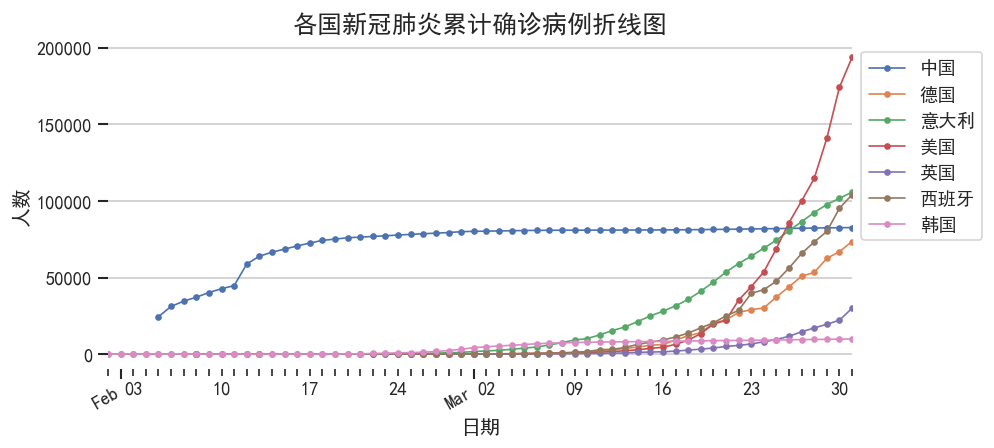

In [119]:
# 绘制多个国家的累计确诊人数折线图
fig, ax = plt.subplots(figsize=(8,4))
data_part['2020-02':].groupby('名称')['累计确诊'].plot(legend=True,marker='o',ms=3,lw=1)
ax.xaxis.set_major_locator(dates.MonthLocator()) #设置间距
ax.xaxis.set_major_formatter(dates.DateFormatter('%b')) #设置日期格式
fig.autofmt_xdate() #自动调整日期倾斜
plt.title('各国新冠肺炎累计确诊病例折线图',size=15)
plt.ylabel('人数')
plt.grid(axis='y')
plt.box(False)
plt.legend(bbox_to_anchor = [1,1])
plt.show()

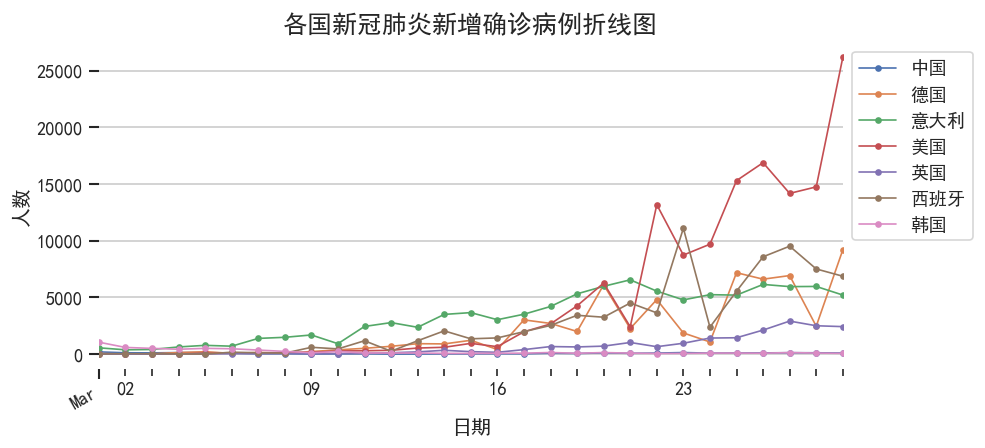

In [120]:
# 绘制各国新增确诊人数折线图
fig, ax = plt.subplots(figsize=(8,4))
data_part['2020-03':'2020-03-29'].groupby('名称')['当日新增确诊'].plot(legend=True,marker
='o',ms=3,lw=1)
ax.xaxis.set_major_locator(dates.MonthLocator()) #设置间距
ax.xaxis.set_major_formatter(dates.DateFormatter('%b')) #设置日期格式
fig.autofmt_xdate() #自动调整日期倾斜
plt.title('各国新冠肺炎新增确诊病例折线图',size=15)
plt.ylabel('人数')
plt.grid(axis='y')
plt.box(False)
plt.legend(bbox_to_anchor = [1,1])
plt.show()

IndexError: list index out of range

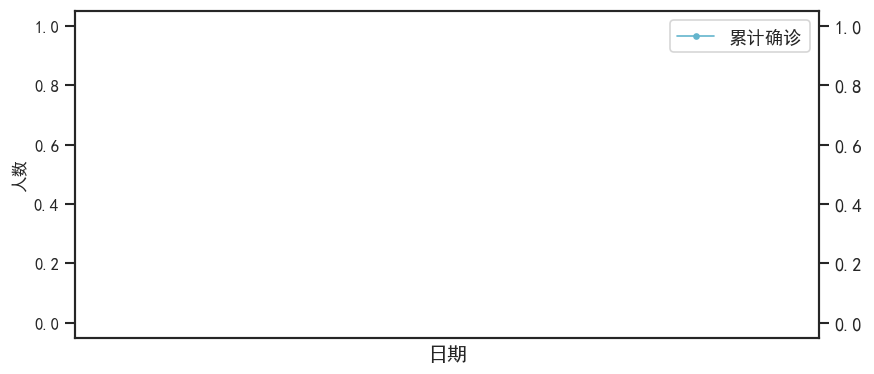

In [122]:
japan = alltime_world[alltime_world['名称']=='日本']
fig, ax = plt.subplots(figsize=(8,4))
japan['累计确诊'].plot(ax=ax, fontsize=10, style='-',lw=1,color='c',marker='o',ms=3,legend=True)
ax.set_ylabel('人数', fontsize=10)
ax1 = ax.twinx()
ax1.bar(japan.index, japan['当日新增确诊'])
ax1.xaxis.set_major_locator(dates.DayLocator(interval = 5))
ax1.xaxis.set_major_formatter(dates.DateFormatter('%b %d'))
ax1.legend(['当日新增确诊'],loc='upper left',bbox_to_anchor=(0.001, 0.9))
plt.grid(axis='y')
plt.box(False)
plt.title('日本新冠肺炎疫情折线图',size=15)
plt.show()

In [123]:
import pyecharts
# 调整配置项
import pyecharts.options as opts
# Map类用于绘制地图
from pyecharts.charts import Map

ModuleNotFoundError: No module named 'pyecharts.options'

In [ ]:
today_world.head()

In [ ]:
contry_name = pd.read_csv('county_china_english.csv', encoding='GB2312')
name_dict = {'中文':'名称'}
# 更改列名
contry_name.rename(columns=name_dict,inplace=True) # inplace参数判断是否在原数据上进行 修改
contry_name.head()

In [ ]:
world_data = pd.merge(today_world, contry_name, on='名称',how='left')
world_data=world_data.drop(['eg_name'],axis=1)
world_data.head()

In [ ]:
heatmap_data = world_data[['英文','当日现存确诊']].values.tolist()
heatmap_data[:10]

In [ ]:
map_ = Map().add(series_name = "现存确诊人数", # 设置提示框标签
                 data_pair = heatmap_data, # 输入数据
                 maptype = "world", # 设置地图类型为世界地图
                 is_map_symbol_show = False # 不显示标记点
                )

In [ ]:
# 设置系列配置项
map_.set_series_opts(label_opts=opts.LabelOpts(is_show=False)) # 不显示国家（标签）名称

In [ ]:
# 设置全局配置项
map_.set_global_opts(title_opts = opts.TitleOpts(title="世界各国家现存确诊人数地图"), # 设 置图标题
 # 设置视觉映射配置项
 visualmap_opts = opts.VisualMapOpts(pieces=[ # 自定义分组的分点和颜 色
 {"min": 10000,"color":"#800000"}, # 栗色
 {"min": 5000, "max": 9999, "color":"#B22222"}, # 耐火砖
 {"min": 999, "max": 4999,"color":"#CD5C5C"}, # 印度红
 {"min": 100, "max": 999,"color":"#BC8F8F"}, # 玫瑰棕色
 {"max": 99, "color":"#FFFFFF"}, # 薄雾玫瑰#FFE4E1
 ],is_piecewise = True)) # 显示分段式图例

In [ ]:
# 在notebook中进行渲染
map_.render_notebook()